In [40]:
import pandas as pd
import numpy as np
import os
import string
import math
from time import localtime, strftime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
def write_csv(ID, Price, filename=""):
    result = pd.DataFrame(columns = ["Id", "SalePrice"])
    result["Id"] = ID
    result["SalePrice"] = Price
    if filename == "":
        filename = "Result_" + strftime("%Y%m%d%H%M", localtime())
    filename = filename + ".csv"
    result.to_csv(os.path.join("./Result/", filename), sep=",", index=False)
    return result

def plot_scatter(x, y, c=3):
    number_feature = []
    for fea, typ in zip(data.columns, data.dtypes):
        if typ == "int64" or typ == "float64":
            number_feature.append(fea)
    nrows = len(number_feature) // c
    ncols = c
    for i, fea in enumerate(number_feature):
        plt.subplot(nrows, ncols, i+1)
        plt.scatter(x[fea], y)
        plt.title(fea)
    plt.show()

In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

data_dir = "./Data/"

train = pd.read_csv(os.path.join(data_dir, "train.csv"))
test = pd.read_csv(os.path.join(data_dir,"test.csv"))
train_Y = train['SalePrice']
train = train.drop(["Id", "SalePrice"], axis=1)
test_id = test["Id"]
test = test.drop(["Id"], axis=1)
data = pd.concat([train, test])

train_num = train.shape[0]
test_num = test.shape[0]
print(data.shape)
print(data.describe())
print(data.isna().sum().sort_values(ascending=False))
print(train.dtypes)

(2919, 79)
        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2919.000000  2433.000000    2919.000000  2919.000000  2919.000000   
mean     57.137718    69.305795   10168.114080     6.089072     5.564577   
std      42.517628    23.344905    7886.996359     1.409947     1.113131   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7478.000000     5.000000     5.000000   
50%      50.000000    68.000000    9453.000000     6.000000     5.000000   
75%      70.000000    80.000000   11570.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  2919.000000   2919.000000  2896.000000  2918.000000  2918.000000   
mean   1971.312778   1984.264474   102.201312   441.423235    49.582248   
std      30.291442     20.894344   179.334253   455.610826   169.205611   
min 

In [43]:
number_feature = []
object_feature = []
for fea, typ in zip(data.columns, data.dtypes):
    if typ == "int64" or typ == "float64":
        number_feature.append(fea)
    if typ == "object":
        object_feature.append(fea)
print("Number_Feature:%i, Object_Feature:%i" %(len(number_feature), len(object_feature)))
print(number_feature)
data.info()

Number_Feature:36, Object_Feature:43
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig      

C:\Users\Hsin-PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


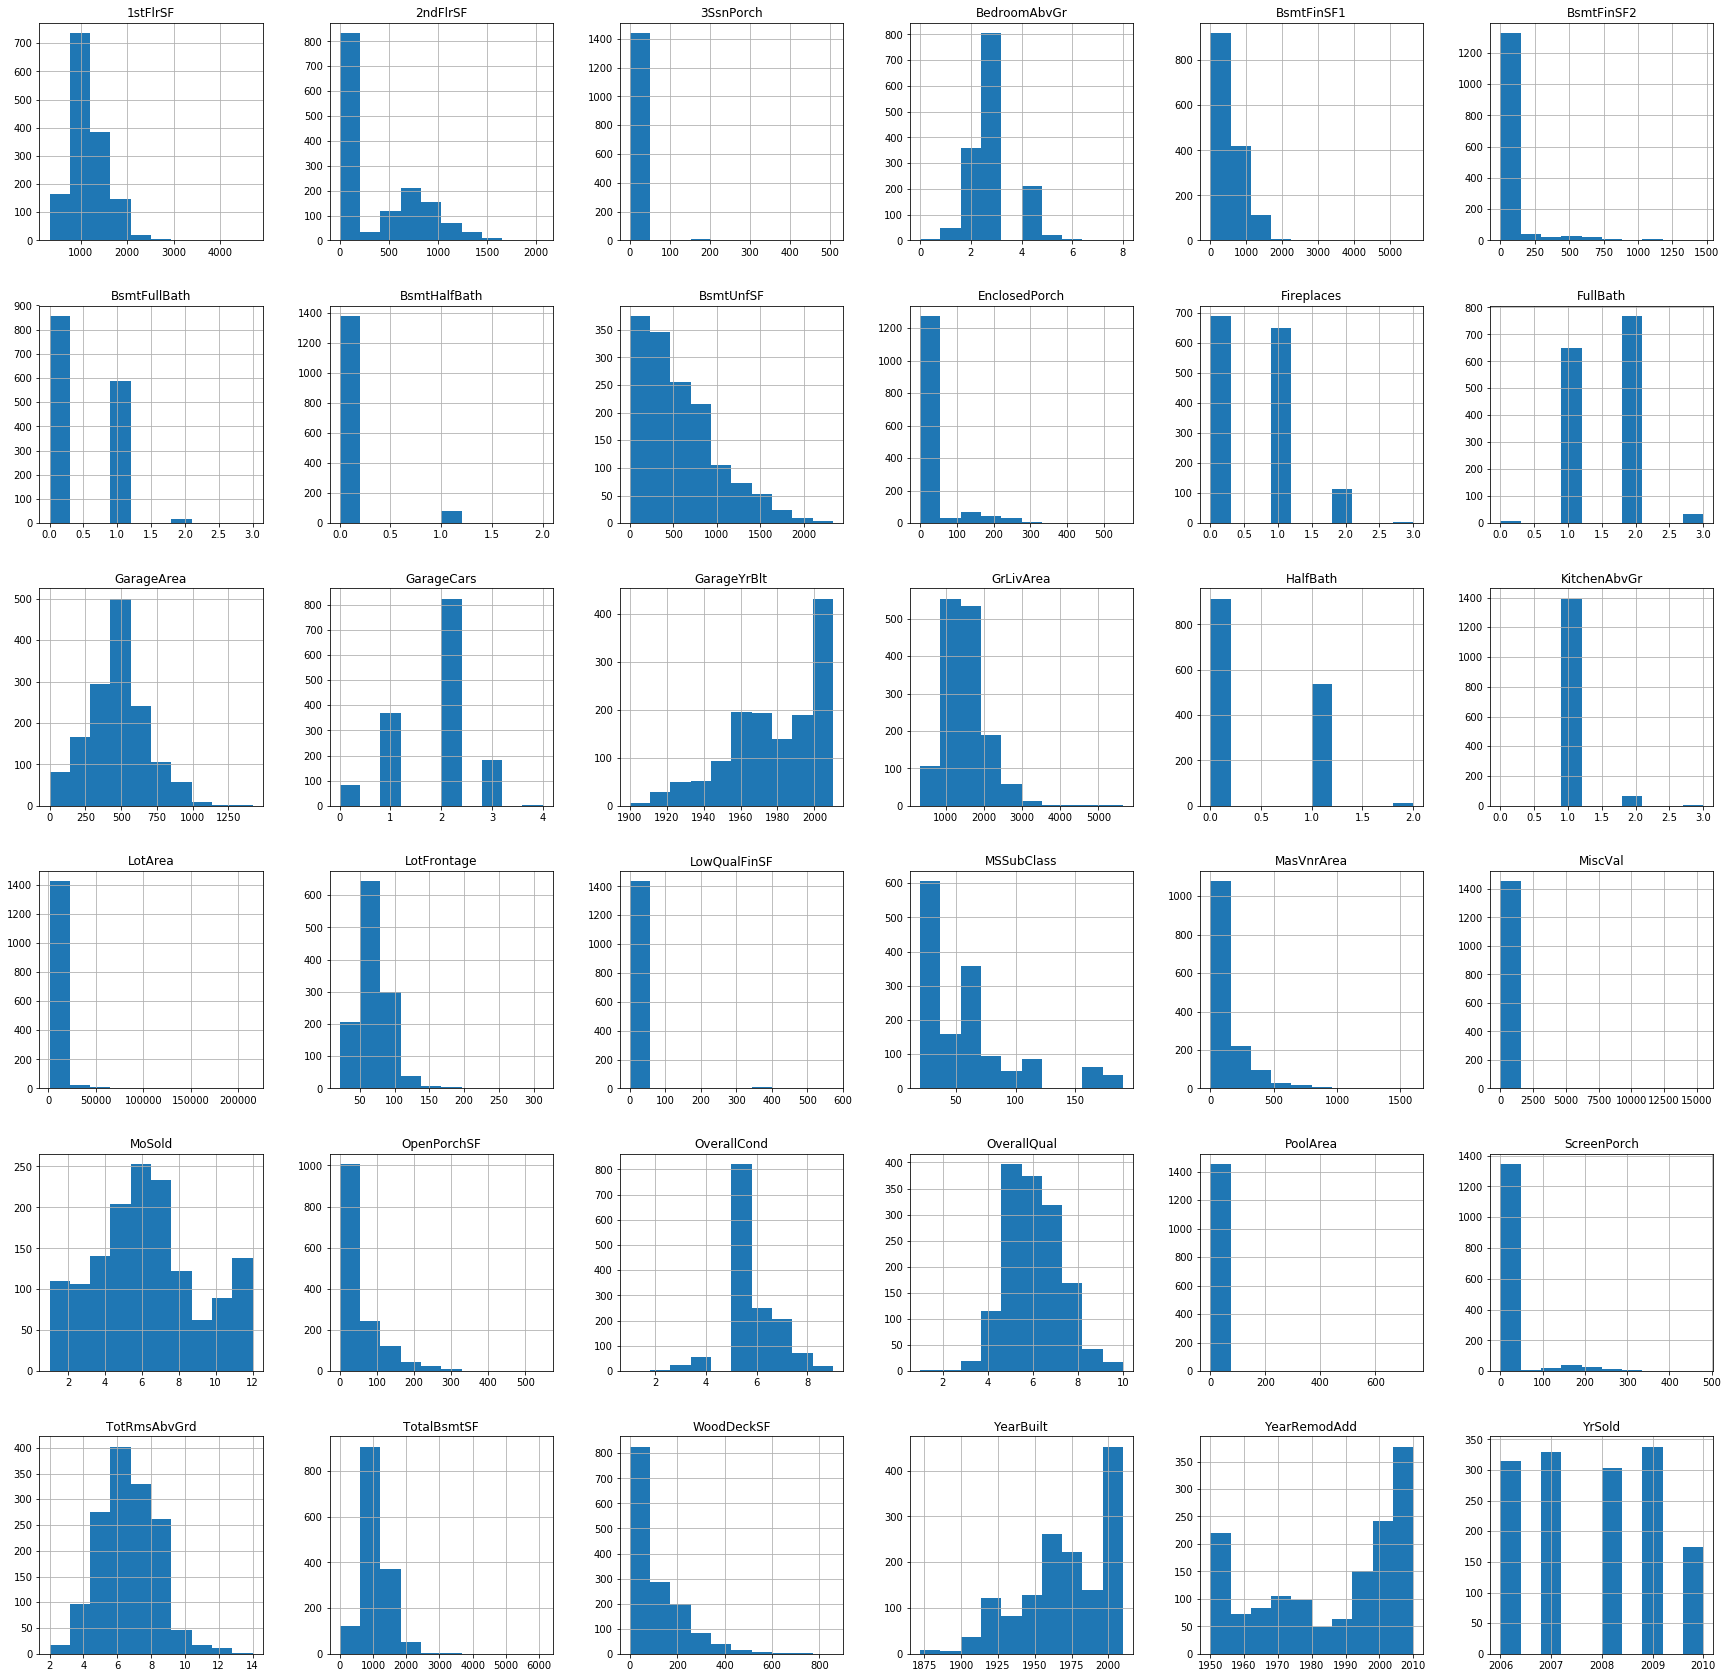

In [44]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
train.hist(ax = ax)
plt.show()

# 缺失值填補

In [45]:
def Missing_Replace(data, fea_array, replace="None"):
    for fea in fea_array:
        if replace == "Mean":
            data[fea] = data[fea].fillna(data[fea].mean())
        elif replace == "Mode":
            data[fea] = data[fea].fillna(str(data[fea].mode()[0]))
        else:
            data[fea] = data[fea].fillna(replace)
    return data

Missing_None = ["MasVnrType", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", 
                "GarageFinish", "GarageCond", "GarageQual", "PoolQC", "Fence", "MiscFeature", "Alley", "Utilities"]
Missing_0 = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "2ndFlrSF",
             "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea", "GarageYrBlt"]
Missing_Mean = ["1stFlrSF"]
Missing_Mode = ["MSZoning", "Exterior1st", "Exterior2nd", "Foundation", "BsmtExposure", "Electrical", 
                "KitchenQual", "Functional", "SaleType"]
data_after = data.copy()
data_after = Missing_Replace(data_after, Missing_None, replace="None")
data_after = Missing_Replace(data_after, Missing_0, replace=0)
data_after = Missing_Replace(data_after, Missing_Mean, replace="Mean")
data_after = Missing_Replace(data_after, Missing_Mode, replace="Mode")
print(data_after.isna().sum().sort_values(ascending=False).head(10))

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
dtype: int64


In [46]:
#plt.figure(figsize=(30,30))
#plot_scatter(train, train_Y, 4)

# Feature Engineering

In [47]:
#去除偏態，把面積資料都取Log
LogTranf_columns = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", 
                    "LowQualFinSF", "GrLivArea", "GarageArea"]
for fea in LogTranf_columns:
    data_after[fea] = np.log(data_after[fea] + 1)

In [48]:
OneHot_columns = ["MSZoning"]
Label_columns = [x for x in object_feature if x not in OneHot_columns]
data_after = pd.get_dummies(data_after, columns=OneHot_columns)

for fea in Label_columns:
    data_after[fea] = LabelEncoder().fit_transform(data_after[fea])

In [49]:
print(data_after.head(5))

   MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandContour  \
0          60         65.0     8450       1      1         3            3   
1          20         80.0     9600       1      1         3            3   
2          60         68.0    11250       1      1         0            3   
3          70         60.0     9550       1      1         0            3   
4          60         84.0    14260       1      1         0            3   

   Utilities  LotConfig  LandSlope  Neighborhood  Condition1  Condition2  \
0          0          4          0             5           2           2   
1          0          2          0            24           1           2   
2          0          4          0             5           2           2   
3          0          0          0             6           2           2   
4          0          2          0            15           2           2   

   BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0 

In [50]:
train_X = data_after.iloc[:train_num,:]
test_x = data_after.iloc[(train_num):,:]
print(train_X.shape, print(train_num))
print(test_x.shape, print(test_num))

1460
(1460, 83) None
1459
(1459, 83) None


In [51]:
temp = train.copy()
temp["SalePrice"] = train_Y
temp_corr = temp.corr()

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


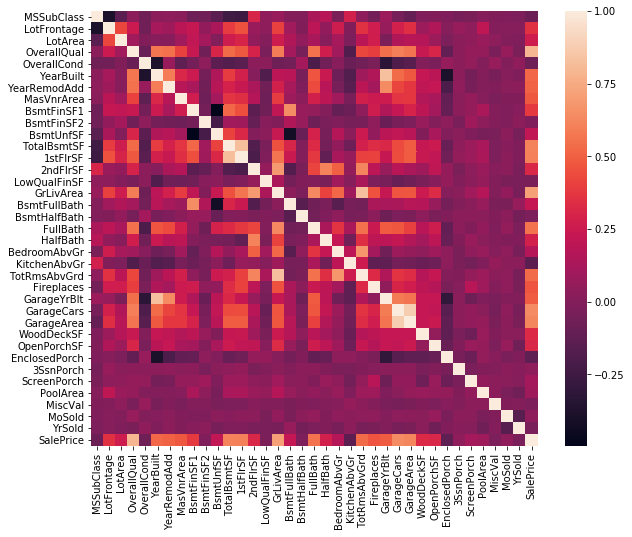

In [52]:
plt.figure(figsize = (10, 8))
print(temp_corr["SalePrice"].sort_values(ascending=False))
sns.heatmap(temp_corr)

In [53]:
x_train, x_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.1, random_state=727)

In [54]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
rmse_train_reg = math.sqrt(mse(y_train, lr_reg.predict(x_train)))
rmse_valid_reg = math.sqrt(mse(y_valid, lr_reg.predict(x_valid)))
print("Train_RMSE: %.2f" %rmse_train_reg)
print("Valid_RMSE: %.2f" %rmse_valid_reg)
y_pred_reg = lr_reg.predict(test_x)
#output = write_csv(test_ID, y_pred_reg, "reg_v1")

Train_RMSE: 31253.07
Valid_RMSE: 23826.01


In [55]:
lasso_reg = Lasso(alpha = 1)
lasso_reg.fit(x_train, y_train)
rmse_train_lasso = math.sqrt(mse(y_train, lasso_reg.predict(x_train)))
rmse_valid_lasso = math.sqrt(mse(y_valid, lasso_reg.predict(x_valid)))
print("Train_RMSE: %.2f" %rmse_train_lasso)
print("Valid_RMSE: %.2f" %rmse_valid_lasso)
y_pred_lasso = lasso_reg.predict(test_x)
#output = write_csv(test_id, y_pred_lasso, "lasso_baseline")

Train_RMSE: 31253.11
Valid_RMSE: 23823.37


In [61]:
ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(x_train, y_train)
rmse_train_ridge = math.sqrt(mse(y_train, ridge_reg.predict(x_train)))
rmse_valid_ridge = math.sqrt(mse(y_valid, ridge_reg.predict(x_valid)))
print("Train_RMSE: %.2f" %rmse_train_ridge)
print("Valid_RMSE: %.2f" %rmse_valid_ridge)
y_pred_ridge = ridge_reg.predict(test_x)
#output = write_csv(test_id, y_pred_ridge, "ridge_baseline")

Train_RMSE: 31263.32
Valid_RMSE: 23819.54


In [59]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(x_train, y_train)
rmse_train_xg = math.sqrt(mse(y_train, xg_reg.predict(x_train)))
rmse_valid_xg = math.sqrt(mse(y_valid, xg_reg.predict(x_valid)))
print("Train_RMSE: %.2f" %rmse_train_xg)
print("Valid_RMSE: %.2f" %rmse_valid_xg)
y_pred_xg = xg_reg.predict(test_x)
output = write_csv(test_id, y_pred_xg, "xgb_v2")

C:\Users\Hsin-PC\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train_RMSE: 14915.07
Valid_RMSE: 22697.27


In [58]:
rf_reg = RandomForestRegressor()
rf_reg.fit(x_train, y_train)
rmse_train_rf = math.sqrt(mse(y_train, rf_reg.predict(x_train)))
rmse_valid_rf = math.sqrt(mse(y_valid, rf_reg.predict(x_valid)))
print("Train_RMSE: %.2f" %rmse_train_rf)
print("Valid_RMSE: %.2f" %rmse_valid_rf)
y_pred_rf = rf_reg.predict(test_x)
#output = write_csv(test_ID, y_pred_rf, "rf_v1")

#rf_reg.importance

C:\Users\Hsin-PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train_RMSE: 13461.25
Valid_RMSE: 25732.72


In [17]:
print(rf_reg.feature_importances_)

[2.15514296e-03 1.93572677e-03 5.92899907e-03 1.71997074e-02
 1.08878263e-05 2.37725670e-04 1.43334161e-03 2.31950229e-03
 0.00000000e+00 1.64118771e-03 8.49369617e-04 7.58787239e-03
 1.27758866e-03 2.91987335e-06 2.87800083e-04 5.79098074e-04
 5.64344208e-01 2.41956462e-03 1.66905400e-02 7.31994931e-03
 9.11696529e-04 5.13040332e-07 1.88939608e-03 1.59255381e-03
 7.42406621e-04 4.95054681e-03 2.90824540e-04 2.70225035e-04
 5.09593773e-04 3.48503744e-03 2.39851215e-04 1.87602492e-03
 1.43545134e-03 4.58086509e-02 1.47977988e-03 3.80028362e-04
 7.10928050e-03 4.45913980e-02 3.26193481e-06 7.17830498e-04
 4.12679893e-03 1.41971312e-04 1.64712689e-02 2.05893059e-02
 4.68564318e-05 1.04798902e-01 7.95760329e-04 6.49013999e-05
 8.08879359e-04 3.43110552e-04 1.75121256e-03 3.47860354e-03
 2.65362463e-03 1.53002267e-02 4.25446181e-04 2.19706513e-03
 1.73140472e-03 5.01816875e-03 3.94911099e-03 1.22539154e-03
 3.06603272e-02 1.51616911e-02 2.03176946e-04 1.88394895e-04
 5.44956586e-04 3.438127

In [116]:
print(xgb.XGBRegressor.__doc__)

Implementation of the scikit-learn API for XGBoost regression.

    Parameters
    ----------
    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    n_estimators : int
        Number of trees to fit.
    verbosity : int
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    silent : boolean
        Whether to print messages while running boosting. Deprecated. Use verbosity instead.
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    nthread : int
        Number of parallel threads used to run xgboost.  (Deprecated, please use ``n_jobs``)
    n_jobs : int
        Number of parallel threads used to run xgboost.  (replaces ``nthread``)
    gamma : float
        Minimum lo